# BI-LSTM + SELF ATTENTION

This notebook aims to introduce a Self-Attention Layer on top of the BI-LSTM model to further improve accuracy

<!-- -- -->

In [14]:
import numpy as np
import os 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention, SpatialDropout1D, GlobalAveragePooling1D, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt


import pickle

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
ARTIFACTS_PATH = "../artifacts"

In [3]:
VOCAB_SIZE = 5000
MAX_LEN = 200
NUM_CLASSES = 5

LOADING THE ARTIFACTS

In [4]:
def load_padded_sequences():
    X_train_pad = np.load(os.path.join(ARTIFACTS_PATH, "X_train_pad.npy"))
    X_test_pad = np.load(os.path.join(ARTIFACTS_PATH, "X_test_pad.npy"))

    return X_train_pad, X_test_pad


def load_labels():
    y_train = np.load(os.path.join(ARTIFACTS_PATH, "y_train.npy"))
    y_test = np.load(os.path.join(ARTIFACTS_PATH, "y_test.npy"))

    return y_train, y_test



X_train_pad , X_test_pad = load_padded_sequences()
y_train, y_test = load_labels()


In [5]:
with open("/Users/sarthaksharna/AutoNews/artifacts/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

<!-- -- -->

MODEL ARCHITECTURE

In [6]:
def create_lstm_attention_model():
    inputs = Input(shape=(MAX_LEN,))

    x = Embedding(input_dim=VOCAB_SIZE, output_dim=128)(inputs)
    x = SpatialDropout1D(0.2)(x)

    lstm_out = LSTM(64, return_sequences=True)(x)

    attention_out = Attention()([lstm_out, lstm_out])

    x = GlobalAveragePooling1D()(attention_out)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [7]:
model = create_lstm_attention_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │    640,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 200, 128)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 200, 64)   │     49,408 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 200, 64)   │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │        325 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 689,989 (2.63 MB)

 Trainable params: 689,861 (2.63 MB)

 Non-trainable params: 128 (512.00 B)

In [8]:

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [9]:
# Train the model
history_attention = model.fit(
    X_train_pad,
    y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.6625 - loss: 1.0308 - val_accuracy: 0.3372 - val_loss: 1.4801
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.9294 - loss: 0.2428 - val_accuracy: 0.8240 - val_loss: 1.3366
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9904 - loss: 0.0683 - val_accuracy: 0.7918 - val_loss: 1.1322
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9963 - loss: 0.0317 - val_accuracy: 0.9091 - val_loss: 1.0584
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.9993 - loss: 0.0138 - val_accuracy: 0.8592 - val_loss: 0.8621
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.9971 - loss: 0.0160 - val_accuracy: 0.7390 - val_loss: 0.9659
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.9985 - loss: 0.0160 - val_accuracy: 0.7155 - val_loss: 1.0023
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9993 - loss: 0.0118 - val_accuracy: 0.

<!-- -- -->

In [10]:
def evaluate_attention_model(model, X_test, y_test, label_encoder):
    # Keras evaluation
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Predictions
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_classes))


evaluate_attention_model(model, X_test_pad, y_test, le)

Test Loss: 0.1450
Test Accuracy: 0.9531
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

Classification Report:
               precision    recall  f1-score   support

     business       0.92      0.96      0.94       101
entertainment       0.97      0.96      0.97        74
     politics       0.95      0.91      0.93        81
        sport       0.96      1.00      0.98       101
         tech       0.98      0.91      0.95        69

     accuracy                           0.95       426
    macro avg       0.96      0.95      0.95       426
 weighted avg       0.95      0.95      0.95       426


Confusion Matrix:
[[ 97   1   3   0   0]
 [  2  71   0   1   0]
 [  3   0  74   3   1]
 [  0   0   0 101   0]
 [  4   1   1   0  63]]


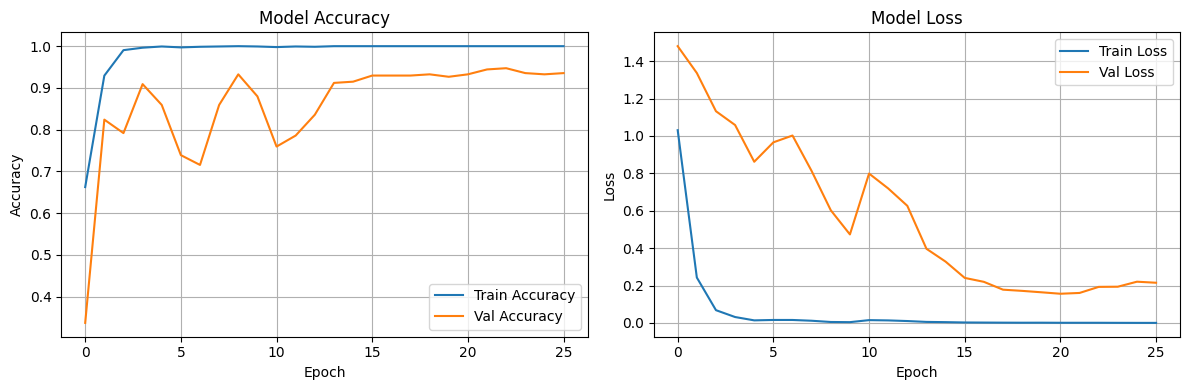

In [13]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    # Accuracy
  
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_curves(history_attention)

In [12]:
model.save(os.path.join(ARTIFACTS_PATH, "lstm_attention.keras"))

<!-- -- -->

INFERENCE:

The BiLSTM model augmented with a self-attention mechanism, Batch Normalization achieves the best overall performance among all experimented architectures, with a test accuracy of ~95.3% and consistently high precision, recall, and F1-scores across all classes

The attention layer enables the model to focus on the most informative tokens in each sequence, improving its ability to capture long-range dependencies and salient contextual cues.

However, the training and validation curves show slight fluctuations rather than perfectly smooth convergence, indicating some degree of optimization instability. This could be due to a relatively higher learning rate, smaller dataset size, or increased model complexity introduced by the attention layer. Despite this, the generalization performance remains strong, and the validation loss continues to follow a downward trend.